## Анализ результатов A/B-тестирования

## Введение

### Заказчик
<font color='#777778'> Интернет-магазин BitMotion Kit. </font>

### Цель проекта

<font color='#777778'> Оценка корректности проведения A/B-теста и анализ его результатов, чтобы определить, повысилось ли количество пользователей, совершающих покупки, после упрощения интерфейса сайта. </font>

### Задачи проекта 

<font color='#777778'>    
    
- Загрузка и предобработка данных
    
- Проверка корректности A/B-теста
    
- Анализ пользовательской активности

- Оценка результатов A/B-теста</font>

### Техническое задание проведённого теста

Гипотеза: упрощение интерфейса приведёт к тому, что в течение семи дней после регистрации в системе конверсия зарегистрированных пользователей в покупателей увеличится как минимум на три процентных пункта.

Параметры теста:

- название теста: `interface_eu_test`;
- группы: А (контрольная), B (новый интерфейс);
- дата набора новых пользователей: с 2020-12-01 по 2020-12-21 включительно;
- дата прохождения теста: с 2020-12-08 по 2020-12-29 включительно.

Необходимо:

* загрузить данные теста;

* проверить корректность его проведения;

* проанализировать полученные результаты.

### Содержимое проекта

<font color='#777778'>

1.   [Описание данных.](#1-bullet)
2.   [Загрузка данных и подготовка их к анализу.](#2-bullet)
3.   [Оценка корректности проведения теста.](#3-bullet)
4.   [Исследовательский анализ данных.](#4-bullet)
5.   [Анализ А/B тестирования.](#5-bullet)
6.   [Общий вывод.](#6-bullet)
</font>

---

<a class="anchor" id="1-bullet"></a>
## Описание данных

- `https://code.s3.yandex.net/datasets/ab_test_participants.csv` — таблица участников тестов.

  Структура файла:

  - `user_id` — идентификатор пользователя;
  - `group` — группа пользователя;
  - `ab_test` — название теста;
  - `device` — устройство, с которого происходила регистрация.


- `https://code.s3.yandex.net/datasets/ab_test_events.zip` — архив с одним `csv`-файлом, в котором собраны события 2020 года;

  Структура файла:

  - `user_id` — идентификатор пользователя;
  - `event_dt` — дата и время события;
  - `event_name` — тип события;
  - `details` — дополнительные данные о событии.

<a class="anchor" id="2-bullet"></a>
## Загрузка данных и подготовка их к анализу.

In [1]:
# Импорт библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Загрузка данных

URL = 'https://code.s3.yandex.net/datasets/'
participants = pd.read_csv(URL + 'ab_test_participants.csv')
events = pd.read_csv(URL + 'ab_test_events.zip', parse_dates=['event_dt'], dtype={'details': str})

Посмотрим содержимое датасетов, выведя первые 5 строк.

In [3]:
participants.head(5)

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


In [4]:
events.head(5)

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


In [5]:
# Проверка данных
print(participants.info())
print(events.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB
None


Удалим все полные дубликаты, участников, попавших в оба теста, пользователей, чьи даты регистрации не попадают в нужный срок.

In [6]:
# Удаление полных дубликатов
participants = participants.drop_duplicates()
events = events.drop_duplicates()

# Удаление записей с user_id = 'GLOBAL'
events = events[events['user_id'] != 'GLOBAL']

# Определение пользователей, участвующих в обоих тестах
users_in_both_tests = participants.groupby('user_id')['ab_test'].nunique()
users_in_both_tests = users_in_both_tests[users_in_both_tests > 1].index

# Удаление этих пользователей
participants = participants[~participants['user_id'].isin(users_in_both_tests)]
events = events[~events['user_id'].isin(users_in_both_tests)]

# Фильтрация по датам регистрации
registration_dates = events[events['event_name'] == 'registration']
registration_dates = registration_dates.groupby('user_id')['event_dt'].min().reset_index()
registration_dates.columns = ['user_id', 'registration_dt']

# Добавление даты регистрации в participants
participants = participants.merge(registration_dates, on='user_id', how='left')

# Фильтрация по периоду регистрации
participants = participants[
    (participants['registration_dt'] >= '2020-12-01') &
    (participants['registration_dt'] <= '2020-12-22')
]

# Удаление пользователей, у которых нет даты регистрации в указанном периоде
events = events[events['user_id'].isin(participants['user_id'])]

print(f"Количество записей в participants: {len(participants)}")
print(f"Количество записей в events: {len(events)}")

Количество записей в participants: 11754
Количество записей в events: 80001


Оценим количество пропусков в `events['details']`

In [7]:
print(round (1 - events['details'].count()/events.shape[0], 2))

0.72


In [8]:
events.groupby('event_name')['details'].count()

event_name
login               0
product_cart        0
product_page        0
purchase        10468
registration    11754
Name: details, dtype: int64

**Вывод:**

- Все типы данных соответсвуют ожидаемым.
- Датасет `participants` не имеет пропусков.
- В датасете `events` пропуски есть только в столбце  `details`, однако они встречаются для событий `purchase` и `registration` и являются естсественными (если на привлечения клиента (`registration`) не было ничего потрачено или пользователь не совершал покупку (`purchase`), то данные не заполнены)
- Количество участников теста после фильтрации: 11 754.
- Количество событий, связанных с этими пользователями: 80 001.

<a class="anchor" id="3-bullet"></a>
## Оценка корректности проведения теста.

На данном этапе проведем проверку корректности технического задания.

Проверим корректность дат регистрации.

In [9]:
print(participants['registration_dt'].min(), participants['registration_dt'].max())

2020-12-06 14:10:01 2020-12-21 23:58:34


Даты регистрации попадают в указанный период (с 2020-12-01 по 2020-12-21).

Проверим распределение пользователей

In [10]:
# Подсчет записей по каждому тесту и каждой группе
participants.groupby(['ab_test', 'group'])['user_id'].nunique()

ab_test                  group
interface_eu_test        A        4442
                         B        4524
recommender_system_test  A        2082
                         B         706
Name: user_id, dtype: int64

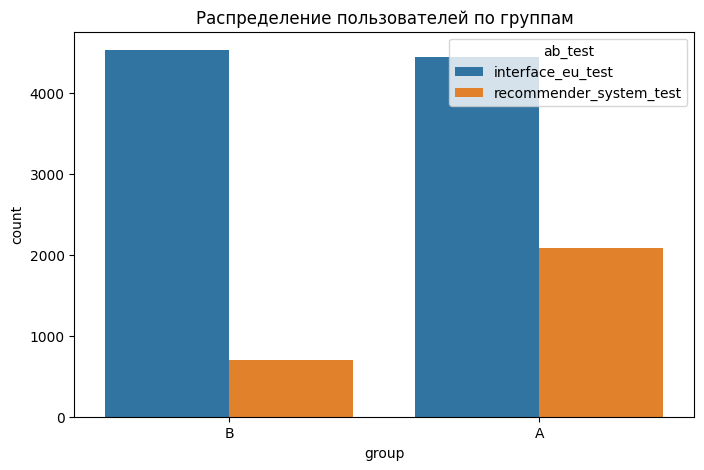

In [11]:
plt.figure(figsize=(8, 5))
sns.countplot(data=participants, 
              x='group', 
              hue='ab_test')
plt.title("Распределение пользователей по группам")
plt.show()

Проверим пересечения в группах.

In [12]:
# Отберем группы  
group_a=participants.query("ab_test == 'interface_eu_test'") 
group_b=participants.query("ab_test == 'recommender_system_test'") 
  
# id пользователей, попавших в обе группы 
group_intersections=list(np.intersect1d(group_a['user_id'], group_b['user_id']))
print('Количество пользователей, попавших в обе группы = ', len(group_intersections))
print('Доля пользователей, попавших в обе группы = ', round (len(group_intersections)/participants.shape[0],2))

Количество пользователей, попавших в обе группы =  0
Доля пользователей, попавших в обе группы =  0.0


Пересечения отсутствуют.

Проверим сколько пользователей попало в каждую группу.

In [13]:
print ('Количество пользователей в группе A = ', len(participants.query('group == "A"')))
print ('Количество пользователей в группе B = ', len(participants.query('group == "B"')))
print ('Доля пользователей группы A  = ', round(len(participants.query('group == "A"')) / len (participants), 2))
print ('Доля пользователей группы B  = ', round(len(participants.query('group == "B"')) / len (participants), 2))

Количество пользователей в группе A =  6524
Количество пользователей в группе B =  5230
Доля пользователей группы A  =  0.56
Доля пользователей группы B  =  0.44


Оценим сколько пользователей учавствовали в тесте (совершали действия)

In [14]:
# Объединение таблиц с участниками теста и событиями
participants_events = events.merge(participants, how='left', on='user_id').dropna(axis='index', how='any',subset=['group'])

In [15]:
# Уникальные пользователи, совершившие действия
active_users = participants_events['user_id'].nunique()
active_users

11754

Итоговая проверка разделения на группы, в которой будут только те пользователи, которые участвовали в тесте.

In [16]:
# Группировка по группам и подсчёт уникальных пользователей
df_count_group = participants_events.groupby('group', as_index=False).agg({'user_id': 'nunique'}).rename(columns={'user_id': 'count'})

# Доля пользователей
part_users_A = round(participants_events.query('group == "A"')['user_id'].nunique() / active_users, 2)
part_users_B = 1 - part_users_A

df_count_group['part'] = [part_users_A * 100, part_users_B * 100]

df_count_group['part'] = df_count_group['part'].round().astype(int).astype(str) + '%'

df_count_group

,group,count,part
0,A,6524,56%
1,B,5230,44%


**Вывод:**

- Даты регистрации попадают в указанный период (с 2020-12-01 по 2020-12-21).
- Распределение близко к равномерному, но есть небольшой перекос в сторону группы A.
- Пользователи, участвующие одновременно в двух тестах, отсутствуют.
- Данные подготовлены корректно.

Оценим достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры: 

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

In [17]:
p1 = 0.30  
p2 = 0.33  # Ожидаемая конверсия 
alpha = 0.05  
power = 0.80 

z_alpha = norm.ppf(1 - alpha / 2)
z_beta = norm.ppf(power)

n = ((z_alpha + z_beta) ** 2 * (p1 * (1 - p1) + p2 * (1 - p2))) / ((p2 - p1) ** 2)

n = int(np.ceil(n))

print(f'Минимальный размер выборки для каждой группы: {n}')

Минимальный размер выборки для каждой группы: 3760


**Вывод:**

3760 пользователей - минимальный размер выборки для каждой группы, необходимый для увеличения конверсии на 3%.
Фактический размер: 6524 пользователей в группе А, 5230 пользователей в группе B. Выборка в обеих группах превышает минимально необходимый размер, что позволяет получить статистически значимые результаты.

<a class="anchor" id="4-bullet"></a>
## Исследовательский анализ данных

Проанализируем данные о пользовательской активности по таблице `ab_test_events`:

- оставим события, связанные с участвующими в изучаемом тесте пользователями;

In [18]:
# Объединение таблиц participants и events
participants_events = events.merge(participants, on='user_id', how='inner')
# Фильтрация данных только для участников теста interface_eu_test
participants_events = participants_events[participants_events['ab_test'] == 'interface_eu_test']

- определим горизонт анализа: рассчитаем время (лайфтайм) совершения события пользователем после регистрации и оставим только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [19]:
# Лайфтайм 
participants_events['lifetime'] = (participants_events['event_dt'] - participants_events['registration_dt']).dt.days

# События, выполненные в течение первых 7 дней
participants_events = participants_events[participants_events['lifetime'] < 7]

participants_events

,user_id,event_dt,event_name,details,group,ab_test,device,registration_dt,lifetime
0,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,0.0,A,interface_eu_test,iPhone,2020-12-06 14:10:01,0
1,51278A006E918D97,2020-12-06 14:37:25,registration,-3.8,A,interface_eu_test,Android,2020-12-06 14:37:25,0
2,A0C1E8EFAD874D8B,2020-12-06 17:20:22,registration,-3.32,B,interface_eu_test,iPhone,2020-12-06 17:20:22,0
3,275A8D6254ACF530,2020-12-06 19:36:54,registration,-0.48,A,interface_eu_test,iPhone,2020-12-06 19:36:54,0
4,0B704EB2DC7FCA4B,2020-12-06 19:42:20,registration,0.0,B,interface_eu_test,PC,2020-12-06 19:42:20,0
...,...,...,...,...,...,...,...,...,...
78283,14546A7337736CDF,2020-12-28 17:36:04,product_cart,NaN,B,interface_eu_test,Android,2020-12-21 22:55:45,6
78288,14546A7337736CDF,2020-12-28 17:37:12,product_cart,NaN,B,interface_eu_test,Android,2020-12-21 22:55:45,6
78313,095ECC5A0FF88329,2020-12-28 17:56:02,product_page,NaN,A,interface_eu_test,iPhone,2020-12-21 20:59:45,6
78364,91A742C3EFE98B9E,2020-12-28 19:00:42,login,NaN,A,interface_eu_test,Mac,2020-12-21 20:58:51,6


- рассчитаем для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [20]:
# Количество уникальных пользователей, сделавших покупку
purchasing_users = participants_events[participants_events['event_name'] == 'purchase'].groupby('group')['user_id'].nunique()

# Общее количество уникальных пользователей в каждой группе
total_users = participants_events.groupby('group')['user_id'].nunique()

print(f'Количество пользователей, сделавших покупку: \n {purchasing_users}')
print(f'Общее количество пользователей: \n {total_users}')

Количество пользователей, сделавших покупку: 
 group
A    1210
B    1315
Name: user_id, dtype: int64
Общее количество пользователей: 
 group
A    4442
B    4524
Name: user_id, dtype: int64


- сделаем предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

In [21]:
# Конверсия в покупку
conversion_rate = purchasing_users / total_users

print(f'Конверсия в покупку: \n {conversion_rate}')

Конверсия в покупку: 
 group
A    0.272400
B    0.290672
Name: user_id, dtype: float64


**Вывод:**
- Количество пользователей, сделавших покупку: группа A (контрольная): 1210 пользователей, группа B (тестовая): 1315 пользователей.

- Общее количество пользователей: группа A: 4442 пользователей, группа B: 4524 пользователей.

- Конверсия в покупку:группа A: 27.24%, группа B: 29.07%.

- Разница в конверсии между группами составляет 1.83%. Ожидаемый эффект в 3% не достигается.

<a class="anchor" id="5-bullet"></a>
## Анализ А/B тестирования

Проведем оценку результатов A/B теста.

- Проверьте изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

Нулевая гипотеза $(H_0)$: Конверсия в группе B не больше конверсии в группе А. $H_0: p_B \leq p_A$

Альтернативная гипотеза $(H_1)$: Конверсия в группе B больше, чем в группе A. $H_1: p_B > p_A$

In [22]:
# Фильтрация для каждой группы
group_A = participants_events[participants_events['group'] == 'A'].query('ab_test == "interface_eu_test"')
group_B = participants_events[participants_events['group'] == 'B'].query('ab_test == "interface_eu_test"')

# Пользователи, сделавших покупку 
successes = [
    group_B[group_B['event_name'] == 'purchase'].query('ab_test == "interface_eu_test"')['user_id'].nunique(), 
    group_A[group_A['event_name'] == 'purchase'].query('ab_test == "interface_eu_test"')['user_id'].nunique() 
]

# Всего пользователей 
nobs = [
    group_B['user_id'].nunique(),  
    group_A['user_id'].nunique()   
]

z_stat, p_value = proportions_ztest(successes, 
                                    nobs, 
                                    alternative='larger')  # H1: конверсия в B > конверсии в A

alpha = 0.05

print(f"Z-статистика: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# Интерпретация результатов
if p_value < alpha:
    print(f'p-value={p_value:.4f} < {alpha}')
    print('Отвергаем нулевую гипотезу: конверсия в группе B статистически значимо выше, чем в группе A.')
else:
    print(f'p-value={p_value:.4f} >= {alpha}')
    print('Не получилось отвергнуть нулевую гипотезу: конверсия в группе B не является статистически значимо выше, чем в группе A.')

Z-статистика: 1.9232
p-value: 0.0272
p-value=0.0272 < 0.05
Отвергаем нулевую гипотезу: конверсия в группе B статистически значимо выше, чем в группе A.


p-value ниже установленного уровня значимости 0.05, мы не можем не отвергнуть нулевую гипотезу, следовательно  конверсия в группе B является статистически значимо выше, чем в группе A.

**Вывод:**
- Разница в конверсии  является статистически значимой.
- Ожидаемый эффект (увеличение конверсии на 3 процентных пункта) не достигнут. Фактическое увеличение конверсии примерно в 2 раза меньше.
- Результаты A/B-тестирования показывают, что упрощение интерфейса не привело к статистически значимому увеличению конверсии.
- Повышение конверсии было, но ниже ожидаемого эффекта.

<a class="anchor" id="6-bullet"></a>
## Общий вывод

- Данные загружены и очищены от дубликатов, некорректных записей и пользователей, не соответствующих условиям теста. 
- Распределение пользователей по группам близко к равномерному (56% в группе A, 44% в группе B).
- Не обнаружено пользователей, которые учавствовали в двух тестах одновременно.
- Выборка достаточна для получения статистически значимых результатов. (Минимальный размер выборки - 3760 пользователей, фактический размер в группе А - 6524 пользователей, 5230 пользователя в группе В.)
- Разница в конверсии между группами составляет 1.83%
- Проведён Z-тест с односторонней гипотезой:
        Нулевая гипотеза (H₀): Конверсия в группе B не больше, чем в группе A.
        Альтернативная гипотеза (H₁): Конверсия в группе B больше, чем в группе A.
- По результатам теста конверсия в группе B является статистически значимо выше, чем в группе A.
- Упрощение интерфейса (изменения в группе B) привело к статистически значимому увеличению конверсии.
- Однако фактическое увеличение конверсии (1.83 процентных пункта) оказалось ниже ожидаемого эффекта (3 процентных пункта). Это может указывать на то, что изменения в интерфейсе оказали положительное влияние, но не столь существенное, как предполагалось.